
First 10 Customers RFM Table:
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12346.0      326          2      0.00        1        2        1   
1     12347.0        2          7   4310.00        5        4        5   
2     12348.0       75          4   1797.24        2        3        4   
3     12349.0       19          1   1757.55        4        1        4   
4     12350.0      310          1    334.40        1        1        2   
5     12352.0       36         11   1545.41        3        5        4   
6     12353.0      204          1     89.00        1        1        1   
7     12354.0      232          1   1079.40        1        1        4   
8     12355.0      214          1    459.40        1        1        2   
9     12356.0       23          3   2811.43        4        3        5   

  RFM_Score          Segment  \
0       121   Lost Customers   
1       545  Loyal Customers   
2       234  Needs Attention   
3       414    Recent Buye

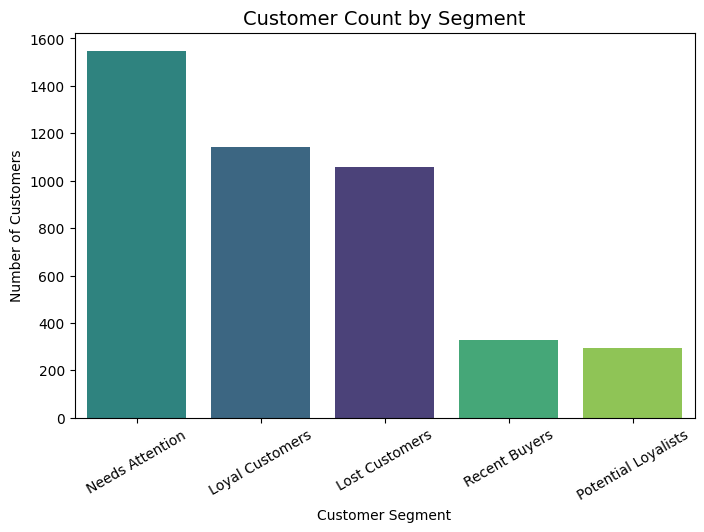

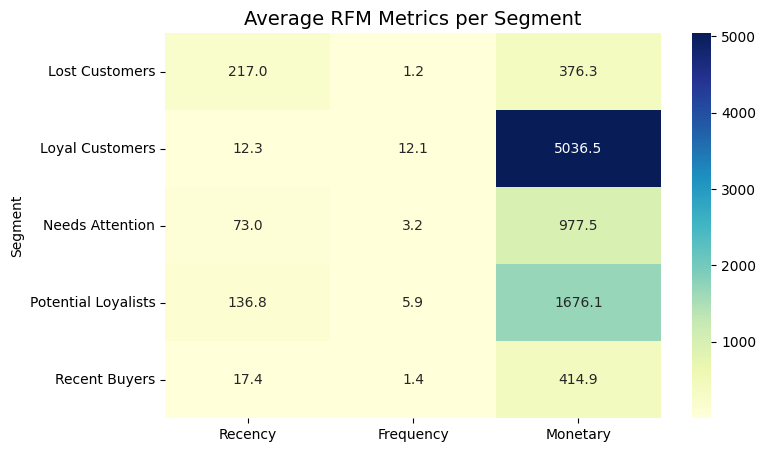


RFM Segmentation saved as RFM_Segmentation.csv


RFM SEGMENTATION SUMMARY REPORT
--------------------------------
Total Customers Analyzed: 4372
Average Recency (days): 92.0
Average Frequency (purchases): 5.1
Average Monetary Value: $1898.46

Customer Segments Count:
Segment
Needs Attention        1547
Loyal Customers        1144
Lost Customers         1058
Recent Buyers           330
Potential Loyalists     293

Total Monetary Contribution by Segment:
Segment
Loyal Customers        5761804.81
Needs Attention        1512118.94
Potential Loyalists     491085.07
Lost Customers          398140.33
Recent Buyers           136916.66



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load Dataset
# -------------------------------
df = pd.read_csv("online_retail.csv", encoding='latin1')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove missing CustomerIDs
df = df.dropna(subset=['CustomerID'])

# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# -------------------------------
# 2. Calculate RFM Metrics
# -------------------------------
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                      # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# -------------------------------
# 3. Assign Scores (1-5 scale)
# -------------------------------
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# -------------------------------
# 4. Segment Customers
# -------------------------------
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'Recent Buyers'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return 'Potential Loyalists'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Lost Customers'
    else:
        return 'Needs Attention'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# -------------------------------
# 5. Marketing Ideas
# -------------------------------
marketing_ideas = {
    'Loyal Customers': 'Offer exclusive discounts or loyalty rewards.',
    'Recent Buyers': 'Send thank-you emails and recommend related products.',
    'Potential Loyalists': 'Encourage repeat purchases with limited-time offers.',
    'Lost Customers': 'Re-engage with special comeback deals.',
    'Needs Attention': 'Personalized recommendations and small discounts.'
}

rfm['Marketing_Idea'] = rfm['Segment'].map(marketing_ideas)

# -------------------------------
# 6. Display Summary Table
# -------------------------------
print("\nFirst 10 Customers RFM Table:")
print(rfm.head(10))

print("\nCustomer Count by Segment:")
print(rfm['Segment'].value_counts())

# -------------------------------
# 7. Visualization
# -------------------------------

# Bar chart: Number of customers per segment
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', hue='Segment',
              order=rfm['Segment'].value_counts().index,
              palette='viridis', legend=False)
plt.title("Customer Count by Segment", fontsize=14)
plt.xticks(rotation=30)
plt.ylabel("Number of Customers")
plt.xlabel("Customer Segment")
plt.show()

# Heatmap: Average RFM metrics per segment
segment_rfm = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

plt.figure(figsize=(8,5))
sns.heatmap(segment_rfm, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title("Average RFM Metrics per Segment", fontsize=14)
plt.show()

# -------------------------------
# 8. Save to CSV
# -------------------------------
rfm.to_csv("RFM_Segmentation.csv", index=False)
print("\nRFM Segmentation saved as RFM_Segmentation.csv")

# -------------------------------
# 9. Summary Report (NEW)
# -------------------------------
summary = {
    "Total_Customers": rfm['CustomerID'].nunique(),
    "Average_Recency": round(rfm['Recency'].mean(), 1),
    "Average_Frequency": round(rfm['Frequency'].mean(), 1),
    "Average_Monetary": round(rfm['Monetary'].mean(), 2)
}

segment_counts = rfm['Segment'].value_counts()
segment_monetary = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

report = f"""
RFM SEGMENTATION SUMMARY REPORT
--------------------------------
Total Customers Analyzed: {summary['Total_Customers']}
Average Recency (days): {summary['Average_Recency']}
Average Frequency (purchases): {summary['Average_Frequency']}
Average Monetary Value: ${summary['Average_Monetary']}

Customer Segments Count:
{segment_counts.to_string()}

Total Monetary Contribution by Segment:
{segment_monetary.round(2).to_string()}
"""

# Save report to text file
with open("RFM_Summary_Report.txt", "w") as f:
    f.write(report)

print("\n" + report)
